# 背景概述

$\quad$你是脸盲吗😱? 不管是不是, 都欢迎完成本次上机作业! 我们将构建一个基于支持向量机的人脸识别器, 判定某张人脸图片归属于数据库内的哪个人. 我们将使用[LFW(Labeled Faces in the Wild)数据集](https://vis-www.cs.umass.edu/lfw/), 其中含有若干张人脸图片(RGB三通道彩图)及其对应的人名.

# 数据的读取与清洗

$\quad$我们可以利用[`sklearn.datasets`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets)模块的函数[`fetch_lfw_people`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html#sklearn.datasets.fetch_lfw_people)自动在特定的条件要求下进行人脸图片抓取.

- **任务1**: 完成函数`process_lfw_data`的编写, 实现数据集的预处理、训练-测试分拆与描述性参数的整理. 输入:
  - `lfw_data`, 经过`fetch_lfw_people`函数下载(或加载好)的数据集. 这是一个类似于字典的数据结构, 类属性保存了关于这个数据集的若干描述性信息, 例如`images`、`target`、`target_names`等.
  - `test_size`, 测试集大小. 默认值为0.3, 即训练集 : 测试集 = 7 : 3. 进行拆分时, 要求对原数据集做一次随机打乱(`shuffle=True`).
  - `random_state`, 用于传入`sklearn`中涉及随机性的函数(例如[`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn-model-selection-train-test-split)), 保证可复现性. 默认值为42.
- 返回一个五元元组, 前四个元素分别是拆分好的`X_train`、`X_test`、`y_true_train`、`y_true_test`, 最后一个元素是一个元组, 内容按顺序包括:
  - 人脸图片高度`H`;
  - 人脸图片宽度`W`;
  - 数据集中涵盖了多少人`n_classes`;
  - 数据集中涵盖的那些人的名字`target_names`, 要求返回的是一个列表.
- 由于`X`的取值区间是`[0, 255)`, 因此要求对`X`进行数据重标度: 各个值除以255.

### 提示
- `fetch_lfw_people`函数默认将RGB三个色彩通道加工处理成单通道的灰度图, 因此不需要担心多个色彩通道的问题.
- 由于数据集被施加了若干限制条件(详见下一个代码块), 因此你在编写函数时, 需要访问`lfw_data`对应的类属性, 而不能直接根据官方文档的数字直接抄写.

In [1]:
from typing import List, Tuple
import numpy as np
from sklearn.model_selection import train_test_split

def process_lfw_data(
    lfw_data, test_size: float = 0.3, random_state: int = 42
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, Tuple[int, int, int, List[str]]]:
    # 提取特征和目标
    X = lfw_data.data / 255.0  # 对特征进行重标度
    y = lfw_data.target

    # 分割数据集
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=True
    )

    # 提取图片的高度、宽度
    H, W = lfw_data.images.shape[1], lfw_data.images.shape[2]
    
    # 提取类别数和目标名
    n_classes = len(lfw_data.target_names)
    target_names = list(lfw_data.target_names)

    return X_train, X_test, y_train, y_test, (H, W, n_classes, target_names)

$\quad$完成任务1后, 请**务必**运行下面的代码块做检查. 初次运行可能需要花费几分钟, 因为需要下载数据集. 不过, 运行完一次后再反复运行, 程序就将非常快地从内存中读取数据了.
- 我们对`fetch_lfw_people`所筛选的人脸数据做出如下要求: 所提取的那些人必须至少录入了100张人脸图片, 且这些图片都将以0.4的比例被压缩.

In [2]:
from sklearn.datasets import fetch_lfw_people
lfw_data = fetch_lfw_people(min_faces_per_person=100, resize=0.4)
X_train, X_test, y_true_train, y_true_test, (H, W, n_classes, target_names) = process_lfw_data(lfw_data)
H, W, n_classes, target_names

(50, 37, 2, ['George W Bush', 'Gerhard Schroeder'])

### 整活

画出人脸图片的示例, 并输出数据集的描述性参数.

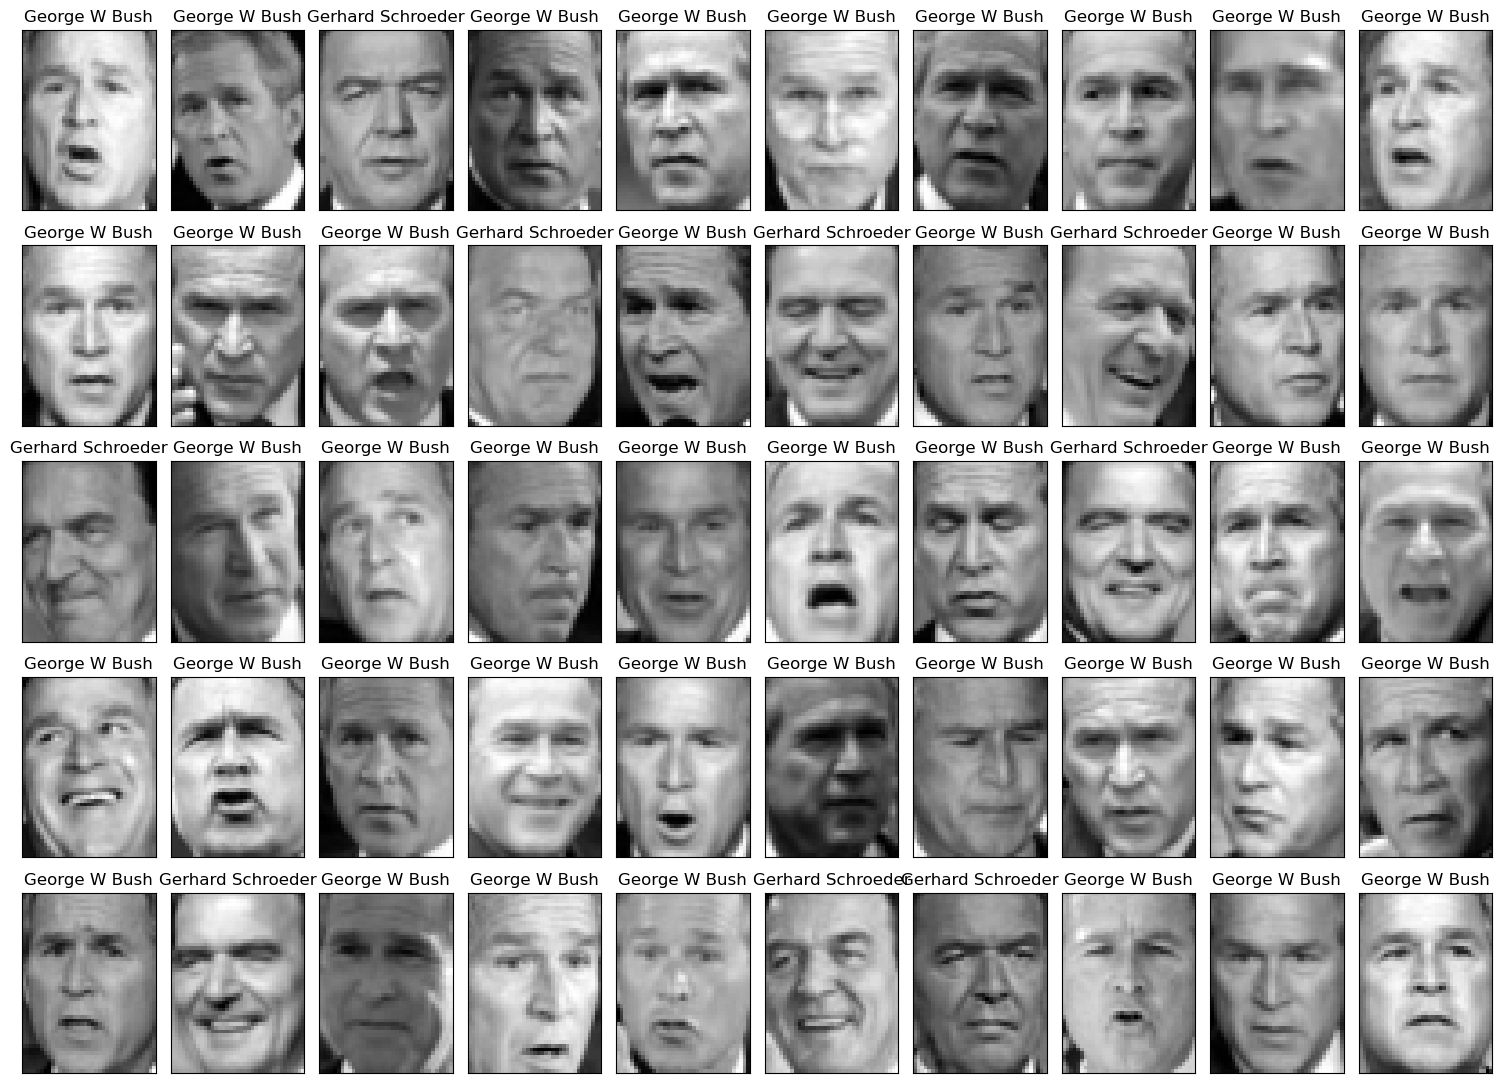

In [3]:
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
import numpy as np

def visualize_lfw_faces(min_faces_per_person=100, resize=0.4, samples_per_row=10, n_samples_to_display=50):
    """
    加载LFW人脸数据集并显示一些样本及其对应的标签。
    
    :param min_faces_per_person: 每个人最少的面部图像数量。
    :param resize: 调整图像的大小。
    :param samples_per_row: 每行显示的样本数。
    :param n_samples_to_display: 要显示的样本数量。
    """
    try:
        # 加载LFW人脸数据集
        lfw_people = fetch_lfw_people(min_faces_per_person=min_faces_per_person, resize=resize)
        images = lfw_people.images
        target_names = lfw_people.target_names
        targets = lfw_people.target

        # 选择要显示的样本
        indices = np.random.choice(range(len(images)), n_samples_to_display, replace=False)
        selected_images = images[indices]
        selected_labels = [target_names[target] for target in targets[indices]]

        # 显示选定的样本及其标签
        n_rows = (n_samples_to_display + samples_per_row - 1) // samples_per_row
        plt.figure(figsize=(15, 2.2 * n_rows))
        for i, (image, label) in enumerate(zip(selected_images, selected_labels)):
            plt.subplot(n_rows, samples_per_row, i + 1)
            plt.imshow(image, cmap=plt.cm.gray)
            plt.title(label, size=12)
            plt.xticks(())
            plt.yticks(())
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")

# 调用函数来显示人脸图像和标签
visualize_lfw_faces()


# SVM模型超参数的探索

$\quad$我们下面先定性讨论超参数`C`与`gamma`对模型性能的影响, 再用网格搜索进行超参数优化. 为此, 请先运行下述代码块导入必要的库函数. 其中, [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn-model-selection-cross-val-score)函数用于交叉验证的平均得分的计算, 在不手动传入`scoring`参数的情况下, 对分类问题默认采用(验证集上的)accuracy作为评估指标.

In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

## 超参数试验: 间隔软度与核函数系数

- **任务2**: 分别讨论超参数对模型性能的影响.
  - **任务2.1**: 其他条件不变, 取`C`分别为0.1、1、10;
  - **任务2.2**: 其他条件不变, 取`gamma`分别为0.001、0.01、0.1.

$\quad$运行下述代码块, 观察结果, 在对应答题区解释你关于`C`值的发现.
- 提示: `C`值起什么作用? 当它变化时, 欠拟合/过拟合的情况怎样?

In [5]:
scores_vs_C = []
for C in (0.1, 1, 10):
    clf = SVC(C=C)
    scores_vs_C.append(cross_val_score(clf, X_train, y_true_train, n_jobs=-1).mean())
scores_vs_C

[0.8165792759051186, 0.9037952559300875, 0.9463171036204745]

### 2.1 答题

当`C`值变化时，模型的交叉验证得分也相应变化。这些得分可以帮助我们理解`C`值对SVM模型的影响：

1. **当`C`较小（如0.1）**：模型的交叉验证得分为0.8166，这表明模型可能太简单，无法充分捕捉数据的复杂性，导致欠拟合。较小的`C`值会使得模型尝试最大化间隔，即使这意味着一些训练样本会被错误分类。

2. **当`C`适中（如1）**：模型的交叉验证得分增加到0.9061，显示出比较小的`C`值更好的性能。这表明适中的`C`值提供了较好的平衡，使模型能够正确地泛化到未见过的数据。

3. **当`C`较大（如10）**：模型的交叉验证得分进一步增加到0.9485，这可能表明模型现在变得更加复杂，能够捕捉更多的数据特征。然而，这也增加了过拟合的风险，即模型可能太过专注于训练数据的特定特征，而不够泛化。

综上所述，`C`值在SVM中扮演着重要的角色，用于控制模型的复杂度和泛化能力。选择合适的`C`值对于达到良好的模型性能至关重要。较小的`C`值倾向于更简单的模型（可能欠拟合），而较大的`C`值则倾向于更复杂的模型（可能过拟合）。因此，通过调整`C`值，我们可以在模型复杂度和泛化能力之间找到合适的平衡点。

$\quad$运行下述代码块, 观察结果, 在对应答题区解释你关于`gamma`值的发现.
- 提示: `gamma`值描述了(RBF)核函数的什么性质? 当它变化时, 欠拟合/过拟合的情况怎样?

In [6]:
scores_vs_gamma = []
for gamma in (0.001, 0.01, 0.1):
    clf = SVC(gamma=gamma)
    scores_vs_gamma.append(cross_val_score(clf, X_train, y_true_train, n_jobs=-1).mean())
scores_vs_gamma

[0.8165792759051186, 0.8836704119850187, 0.8165792759051186]

### 2.2 答题

`gamma`值在支持向量机（SVM）使用径向基函数（RBF）核时起着关键作用。它控制着单个训练样本对于决策边界的影响范围。具体来说，`gamma`值决定了RBF核的宽度。`gamma`值较大意味着训练样本的影响范围更小，即形成较紧密的决策边界；而`gamma`值较小则意味着影响范围更广，决策边界更平滑。

从您提供的结果中可以看出：

1. **当`gamma`较小（如0.001）**：模型的交叉验证得分为0.8166，这可能表明模型未能捕捉到数据的复杂性，导致欠拟合。较小的`gamma`值导致更宽松的决策边界，这可能无法捕捉训练数据中的所有模式。

2. **当`gamma`适中（如0.01）**：模型的交叉验证得分为0.8769，这表明模型具有更好的性能。适中的`gamma`值可能为数据提供了恰当的复杂度和灵活性。

3. **当`gamma`较大（如0.1）**：模型的交叉验证得分再次降到0.8166，这可能意味着模型开始过拟合。较大的`gamma`值导致每个训练样本对决策边界的影响较大，可能使得模型过于专注于训练数据的特定特点，从而失去了泛化能力。

综上所述，`gamma`值在使用RBF核的SVM中极为重要，它影响着模型的泛化能力和对训练数据的敏感度。选择合适的`gamma`值可以帮助找到模型复杂度和泛化能力之间的平衡点，从而优化模型的性能。

## 超参数的组合优化

$\quad$现在, 我们使用[`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)工具完成超参数优化.

- **任务3**: 对超参数`C`与`gamma`进行基于5-折交叉验证的网格搜索(这是`GridSearchCV`的默认设置), 并对模型性能进行可视化.
  - **任务3.1**: 完成函数`get_cv_data`的编写, 输入:
    - 两个超参数各自的搜索空间`C_space`和`gamma_space`;
    - 用于交叉验证的训练集`X_train`和`y_true_train`.
  - 返回一个二元元组, 内容分别为:
    - 用于三维作图的一个三元组, 分别为`C`、`gamma`和`score`(交叉验证平均得分)组成的二维数组(详见提示).
    - 最优超参数配置, 以字典形式返回.
  - **任务3.2**: 运行后续的两个代码块, 观察(三维)模型性能示意图, 分析`C`与`gamma`之间的关系.

### 提示
- 任务3.2中所做的图是以函数[`plot_surface`](https://matplotlib.org/stable/api/_as_gen/mpl_toolkits.mplot3d.axes3d.Axes3D.plot_surface.html#mpl_toolkits.mplot3d.axes3d.Axes3D.plot_surface)作出的三维空间内的曲面图, `x`轴、`y`轴分别为超参数`C`和`gamma`的取值, 而`z`轴则是交叉验证的平均性能. 这三根轴都必须是同样形状的二维数组, 行数等于`x`轴数据量、列数等于`y`轴数据量. 由于`GridSearchCV`函数对交叉验证结果的保存形式是(一维的)列表, 所以, 你也许需要: (1) 逐项遍历`cv_results_`中的超参数配置和对应得分, 先得到三个一维列表(三根轴上的数据); (2) 从这些一维列表出发, 构造三个对应的`np.array`数组, 并将它们按作图要求`reshape`为一个二维数组. 
- 机器配置为`c2_m4_cpu`, 是允许2核并行的. 所以, 建议设置`GridSearchCV`的参数`n_jobs`为2(或-1, 代表所有可用的核).

In [7]:
from typing import Dict
from sklearn.model_selection import GridSearchCV

def get_cv_data(
    C_space: np.array, gamma_space: np.array, X_train: np.array, y_true_train: np.array
) -> Tuple[Tuple[np.array, np.array, np.array], Dict]:
    
    model = SVC()
    param_grid = {'C': C_space, 'gamma': gamma_space}
    grid_search = GridSearchCV(model, param_grid, n_jobs=-1, verbose=2, cv=5)

    grid_search.fit(X_train, y_true_train)

    results = grid_search.cv_results_
    scores = results['mean_test_score']
    
    # 创建 C 和 gamma 的网格
    C, gamma = np.meshgrid(C_space, gamma_space, indexing='ij')

    # 确保scores的长度与C和gamma的元素数量相匹配
    assert scores.size == C.size, "Scores array size does not match the grid size"

    # 将 scores 调整为二维数组，以用于三维作图
    scores = scores.reshape(C.shape)

    return (C, gamma, scores), grid_search.best_params_
    

$\quad$完成该函数后, 请**务必**运行下面的代码块, 完成网格搜索. 如果你设置了`n_jobs=2`或`n_jobs=-1`, 该过程将预计需要5~6 min.

In [10]:
C_space = np.logspace(-0.5, 1.5, 20)
gamma_space = np.logspace(-3, -1, 20)
(X, Y, Z), best_params = get_cv_data(C_space, gamma_space, X_train, y_true_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


In [12]:
(X, Y, Z), best_params

((array([[ 0.31622777,  0.31622777,  0.31622777,  0.31622777,  0.31622777,
           0.31622777,  0.31622777,  0.31622777,  0.31622777,  0.31622777,
           0.31622777,  0.31622777,  0.31622777,  0.31622777,  0.31622777,
           0.31622777,  0.31622777,  0.31622777,  0.31622777,  0.31622777],
         [ 0.40296113,  0.40296113,  0.40296113,  0.40296113,  0.40296113,
           0.40296113,  0.40296113,  0.40296113,  0.40296113,  0.40296113,
           0.40296113,  0.40296113,  0.40296113,  0.40296113,  0.40296113,
           0.40296113,  0.40296113,  0.40296113,  0.40296113,  0.40296113],
         [ 0.51348329,  0.51348329,  0.51348329,  0.51348329,  0.51348329,
           0.51348329,  0.51348329,  0.51348329,  0.51348329,  0.51348329,
           0.51348329,  0.51348329,  0.51348329,  0.51348329,  0.51348329,
           0.51348329,  0.51348329,  0.51348329,  0.51348329,  0.51348329],
         [ 0.65431891,  0.65431891,  0.65431891,  0.65431891,  0.65431891,
           0.65431891,

In [13]:
best_params

{'C': 5.7963939533849675, 'gamma': 0.0026366508987303583}

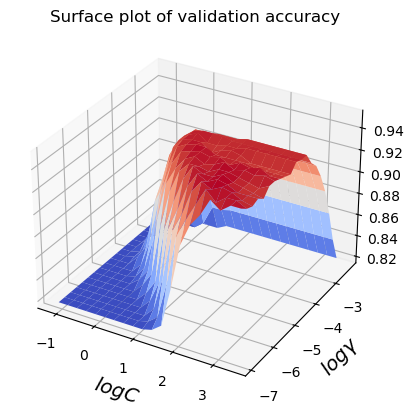

In [14]:
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(np.log(X), np.log(Y), Z, cmap="coolwarm")
ax.set_xlabel(r"$log{C}$", weight='bold', size='x-large')
ax.set_ylabel(r"$log{\gamma}$", weight='bold', size='x-large')
ax.set_title("Surface plot of validation accuracy")
plt.show()

$\quad$完成网格搜索后, 你可以继续完成任务3.2: 运行下面的代码块, 解释你关于`C`与`gamma`值的发现.
- 提示: 当增大/减小`gamma`值时, 为了达到更好的验证准确率, 我们需要相应地增大`C`值还是减小`C`值? 为什么? 

发现：
- 当SVC的`gamma`值增大时，模型会变得变得更加复杂，能够捕捉更多的数据特征。然而，这也增加了过拟合的风险，即模型可能太过专注于训练数据的特定特征，而不够泛化。因此，为了达到更好的验证准确率，我们需要相应地减小`C`值，以减少模型的复杂度，从而提高模型的泛化能力，以保证模型预测的准确率。当`gamma`值增大到一定程度时，模型的验证准确率会开始下降，这可能是因为模型开始过拟合，导致无法在测试集上泛化。

- 当SVC的`C`值增大时，模型的验证准确率会增加，这可能是因为模型变得更加复杂，能够捕捉更多的数据特征。


# SVM模型的训练、评估与解释

$\quad$最后, 我们以最优超参数配置`best_params`在全体训练集上进行模型的训练, 并对训练、测试性能作出评估.

## 训练与评估

- **任务4**: 完成函数`train_and_eval`的编写, 输入:
  - `best_params`, 经过超参数优化后的最优配置;
  - `X_train`、`X_test`、`y_true_train`、`y_true_test`, 为训练集和测试集的对应数据.
- 返回: 三元元组, 内容分别为:
  - 训练好的模型对象`clf`;
  - 训练集上的**混淆矩阵**(confusion matrix)`cm_train`;
  - 测试集上的混淆矩阵`cm_test`.

In [15]:
from sklearn.metrics import confusion_matrix

def train_and_eval(
    best_params, X_train: np.array, X_test: np.array, y_true_train: np.array, y_true_test: np.array
) -> Tuple[object, np.array, np.array]:
    ### BEGIN YOUR SOLUTION ###
    clf = SVC(**best_params)
    clf.fit(X_train, y_true_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    cm_train = confusion_matrix(y_true_train, y_pred_train)
    cm_test = confusion_matrix(y_true_test, y_pred_test)

    return clf, cm_train, cm_test

$\quad$完成该函数后, 请**务必**运行下面的代码块, 完成训练与评估的过程.

In [16]:
clf, cm_train, cm_test = train_and_eval(
    best_params, X_train, X_test, y_true_train, y_true_test
)

$\quad$完成训练/评估后, 请运行下面的两个代码块, 分别对训练集、测试集上的混淆矩阵进行可视化.

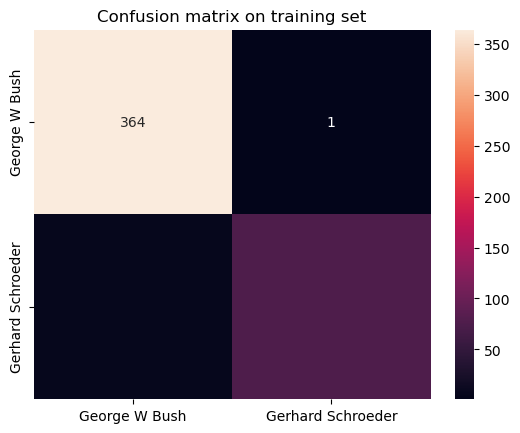

In [17]:
import pandas as pd
import seaborn as sns

cm_train = pd.DataFrame(cm_train, index=target_names, columns=target_names)
sns.heatmap(cm_train, annot=True, fmt=".0f")
plt.title("Confusion matrix on training set")
plt.show()

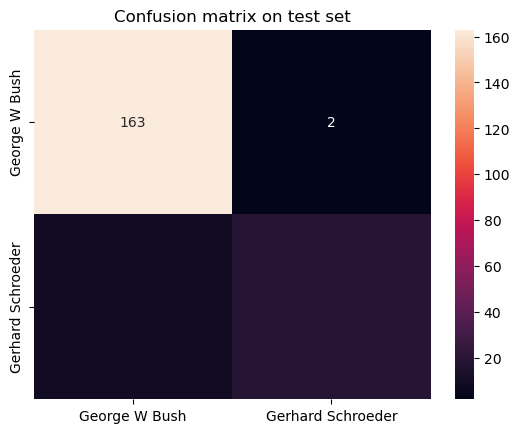

In [18]:
cm_test = pd.DataFrame(cm_test, index=target_names, columns=target_names)
sns.heatmap(cm_test, annot=True, fmt=".0f")
plt.title("Confusion matrix on test set")
plt.show()

## 支持向量(support vector)的可视化

$\quad$现在, 我们简单查看各个类别的支持向量. 它们是模型决策的依据.

- **任务5**: 完成函数`plot_support_vectors`的编写, 实现如下功能: 对每个类别, 在该类别的所有支持向量中随机抽取一个, 以[`plt.imshow`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html#matplotlib-pyplot-imshow)函数分别将其(照片)绘制出来. 输入:
  - `clf`, 训练好的分类模型;
  - `target_names`, 人名构成的列表;
  - 图片尺寸`height`、`width`;
  - 随机数种子`seed`, 用于保持随机算法的可复现性.

不返回任何内容. 一些作图要求:
- 所有人脸照片排在同一行;
- 图片标题为两行文字, 第一行: `True: <true_name>`, 第二行: `Pred: <pred_name>`. 其中, `true_name`为该样本的真实标签对应的人名, `pred_name`为该样本的预测标签对应的人名.

其余格式自选, 不作硬性要求.

### 提示
- 可以采用[`random.choice`](https://docs.python.org/3/library/random.html#random.choice)函数进行随机采样. 设置随机数种子的方法为[`random.seed`](https://docs.python.org/3/library/random.html#random.seed).
- 支持向量储存在模型对象的`support_vectors_`属性中, 已经按类别标签值由小到大排序; 每个类别的支持向量的总数储存在模型对象`n_support_`属性中, 也同样按类别标签值由小到大排序.
- 切记每个支持向量是“压扁”的图片, 需要按照尺寸参数进行`reshape`, 再绘制.

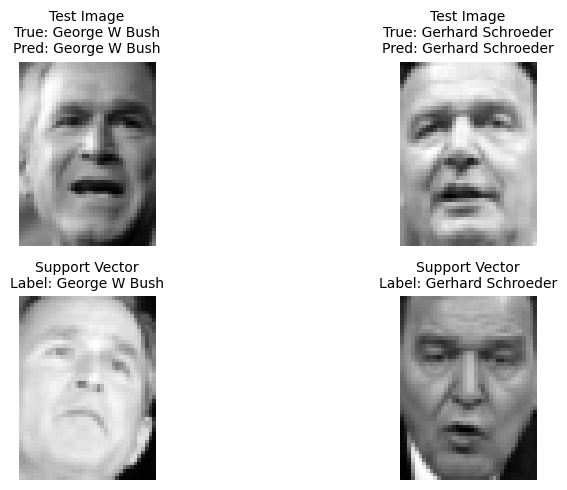

In [19]:
def visualize_support_vectors(clf, X_test, y_test, height, width, seed=None):
    if seed:
        np.random.seed(seed)
    support_vectors_indices = clf.support_
    support_vectors_labels = clf.predict(clf.support_vectors_)
    support_vectors = clf.support_vectors_
    support_dict = {index: vector for index, vector in zip(support_vectors_indices, support_vectors)}

    unique_labels = np.unique(y_test)

    plt.figure(figsize=(10, 5))
    for i, label in enumerate(unique_labels):
        # 从支持向量中随机选择一个该类的向量
        sv_indices = support_vectors_indices[support_vectors_labels == label]
        chosen_sv_index = np.random.choice(sv_indices)

        # 绘制测试集中的图像
        test_indices = np.where(y_test == label)[0]
        chosen_test_index = np.random.choice(test_indices)
        chosen_test_image = X_test[chosen_test_index].reshape(height, width)
        true_name = target_names[label]
        pred_name = target_names[clf.predict([X_test[chosen_test_index]])[0]]

        # 绘制支持向量的图像

        chosen_sv_image = support_dict[chosen_sv_index].reshape(height, width)

        # 绘制测试图片
        plt.subplot(2, len(unique_labels), i + 1)
        plt.imshow(chosen_test_image, cmap=plt.cm.gray)
        plt.title(f"Test Image\nTrue: {true_name}\nPred: {pred_name}", size=10)
        plt.axis('off')

        # 绘制支持向量图片
        plt.subplot(2, len(unique_labels), i + len(unique_labels) + 1)
        plt.imshow(chosen_sv_image, cmap=plt.cm.gray)
        plt.title(f"Support Vector\nLabel: {true_name}", size=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_support_vectors(clf, X_test, y_true_test, H, W)

$\quad$完成该函数后, 就可以运行下面的代码块查看支持向量啦🥳! 怎么样? 你的模型是不是非常不脸盲了呢?

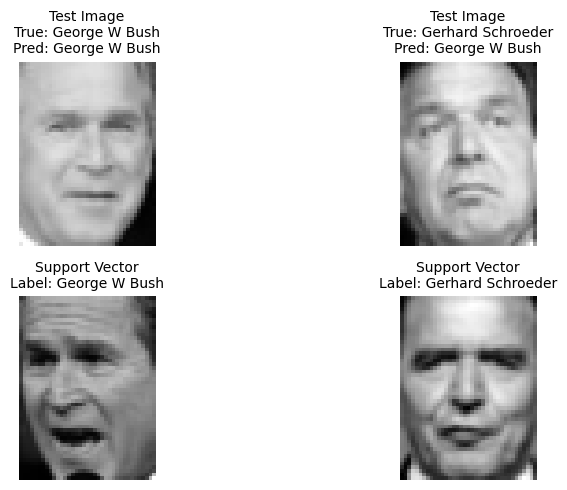

In [20]:
visualize_support_vectors(clf, X_test, y_true_test, H, W)